In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
import numpy as np

In [6]:
data = pd.read_csv('final_merged_data_reduced.csv')
data.head()


,District,Crop,Season,Area (hectares),Yield (quintals),Production (metric tons),Water Consumption (liters/hectare),Water Availability (liters/hectare),Soil Type,pH Level,Organic Matter (%),Nitrogen Content (kg/ha),Phosphorus Content (kg/ha),Potassium Content (kg/ha),Average Soil Moisture,Temperature,Rainfall,Humidity,Price (INR/quintal)
0,Jodhpur,Oilseeds,Kharif,13431.83094,40.438077,5431.574191,8050.000575,7448.173346,Black lava soil,6.828936,1.317088,29.255153,22.513922,48.981804,849.285847,33.5Â°CÂ,406.2 mm,32%,2930.200301
1,Bhilwara,Opium,Kharif,13408.49656,32.656645,4378.765153,8538.202470,8817.853877,Chalky (Calcareous),8.399240,2.276453,25.317040,25.531158,41.003493,504.781794,25.3Â°CÂ,619 mm,51%,2775.330459
2,Sri Ganganagar,Opium,Kharif,15505.96402,37.168265,5763.297838,15038.437310,15299.671430,Sandy,7.227407,3.463635,25.028225,15.392745,37.173035,540.108689,32.9Â°CÂ,303.2 mm,43%,3274.087570
3,Sri Ganganagar,Onion,Kharif,13044.49168,43.870945,5722.741802,7361.595151,7776.958274,Clay,7.285510,2.482385,36.499937,24.801526,31.029041,540.108689,32.9Â°CÂ,303.2 mm,43%,2475.642045
4,Ajmer,Citrus,Kharif,12681.52436,40.939898,5191.803185,13664.465760,13880.325680,Clay,7.420923,3.621546,41.539581,19.092755,39.468315,398.241000,32.7Â°CÂ,571.4Â mm,37.40%,2264.703709


In [13]:
scaler = StandardScaler()
encoder = LabelEncoder()

In [14]:
data['Crop'] = encoder.fit_transform(data['Crop'])
data['Soil Type'] = encoder.fit_transform(data['Soil Type'])

In [15]:
data['Rainfall'] = data['Rainfall'].str.replace(r'[^\d.]', '', regex=True).astype(float)
print(data['Rainfall'].head())

0    406.2
1    619.0
2    303.2
3    303.2
4    571.4
Name: Rainfall, dtype: float64


In [16]:
data['Humidity'] = data['Humidity'].str.replace('%', '').astype(float)
print(data['Humidity'].head())

0    32.0
1    51.0
2    43.0
3    43.0
4    37.4
Name: Humidity, dtype: float64


In [17]:
categorical_cols = ['District', 'Crop', 'Soil Type']
numerical_cols = ['Area (hectares)', 'Yield (quintals)', 'Production (metric tons)',
                  'Water Availability (liters/hectare)', 'pH Level', 'Organic Matter (%)', 
                  'Nitrogen Content (kg/ha)', 'Phosphorus Content (kg/ha)', 
                  'Potassium Content (kg/ha)', 'Average Soil Moisture', 
                  'Rainfall', 'Humidity', 'Price (INR/quintal)']

In [18]:
X = data.drop(columns=['District','Water Consumption (liters/hectare)','Season']) 
y = data['Water Consumption (liters/hectare)']

In [19]:
#mutual information:
mi_scores = mutual_info_regression(X[numerical_cols], y)
mi_scores = pd.Series(mi_scores, index=numerical_cols).sort_values(ascending=False)
print("Mutual Information Scores (numerical features):\n", mi_scores)

Mutual Information Scores (numerical features):
 Water Availability (liters/hectare)    6.648506
Yield (quintals)                       5.034883
Production (metric tons)               5.033134
Price (INR/quintal)                    5.030724
Area (hectares)                        4.892823
Rainfall                               2.290194
Humidity                               2.288194
Average Soil Moisture                  2.286766
Phosphorus Content (kg/ha)             1.997550
Organic Matter (%)                     1.997429
Potassium Content (kg/ha)              1.994336
Nitrogen Content (kg/ha)               1.993877
pH Level                               1.990795
dtype: float64


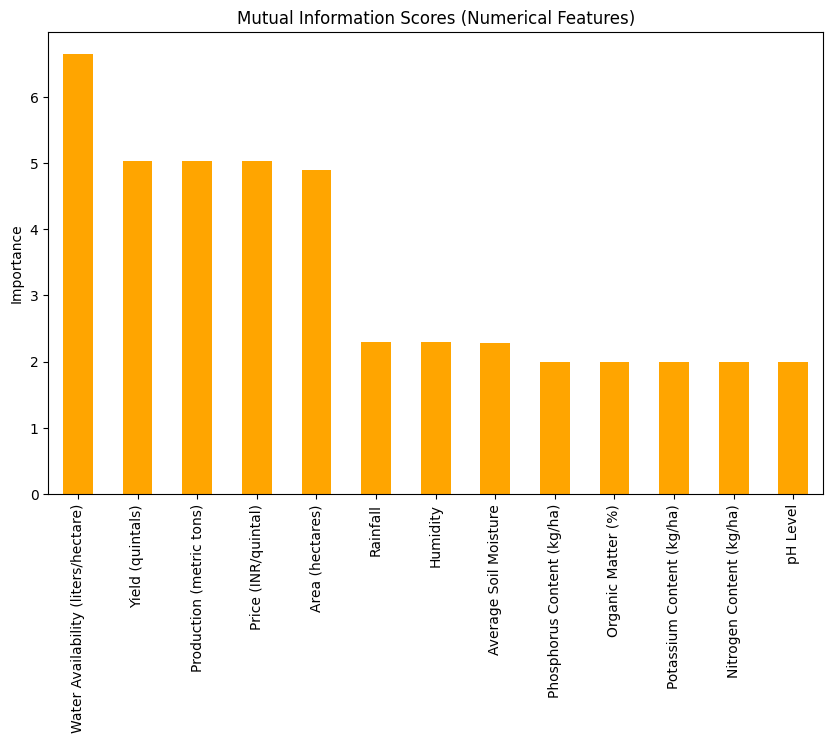

In [20]:
mi_scores.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Mutual Information Scores (Numerical Features)')
plt.ylabel('Importance')
plt.show()

In [21]:
selected_features = ['Water Availability (liters/hectare)', 'Yield (quintals)', 'Production (metric tons)', 
                     'Area (hectares)', 'Humidity', 'Rainfall', 'Average Soil Moisture']

In [22]:
X_selected = data[selected_features]
X_std = scaler.fit_transform(X_selected)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.4, random_state=42)

In [24]:
model = RandomForestRegressor(n_estimators=20,random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

In [25]:
y_pred = model.predict(X_test)
y_pred

array([11870.40554 , 10593.38773 , 11927.85041 , ..., 15473.72064 ,
        8098.752696,  7021.777144])

In [26]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 3.5627071362492244e-22
R² Score: 1.0


In [27]:
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)
print(f"R² on Train Set: {r2_train}")
print(f"R² on Test Set: {r2_test}")

R² on Train Set: 1.0
R² on Test Set: 1.0
